Processing file: input/sinDataComplex.txt
{'file_name': 'sinDataComplex.txt', 'contains_Complex': True, 'contains_LUT': False, 'OSR': 1.0, 'fs': 10000.0, 'complex': 1.0}
1
1
Saved spectrum plot to ./figs/sinDataComplex_spectrum.png


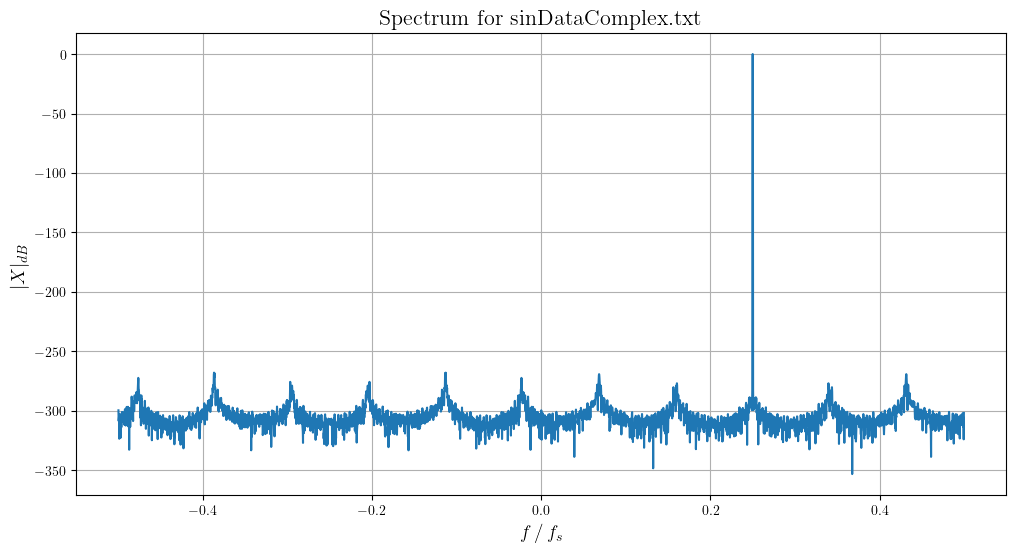

Processed complex data from input/sinDataComplex.txt
Processing file: output/sinDataR_delay_5.txt
{'file_name': 'sinDataR_delay_5.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 1.0}
1
1
Saved spectrum plot to ./figs/sinDataR_delay_5_spectrum.png


/tmp/ipykernel_6935/3770428867.py:88: RuntimeWarning: divide by zero encountered in log10
  spectrum = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(data_win))))


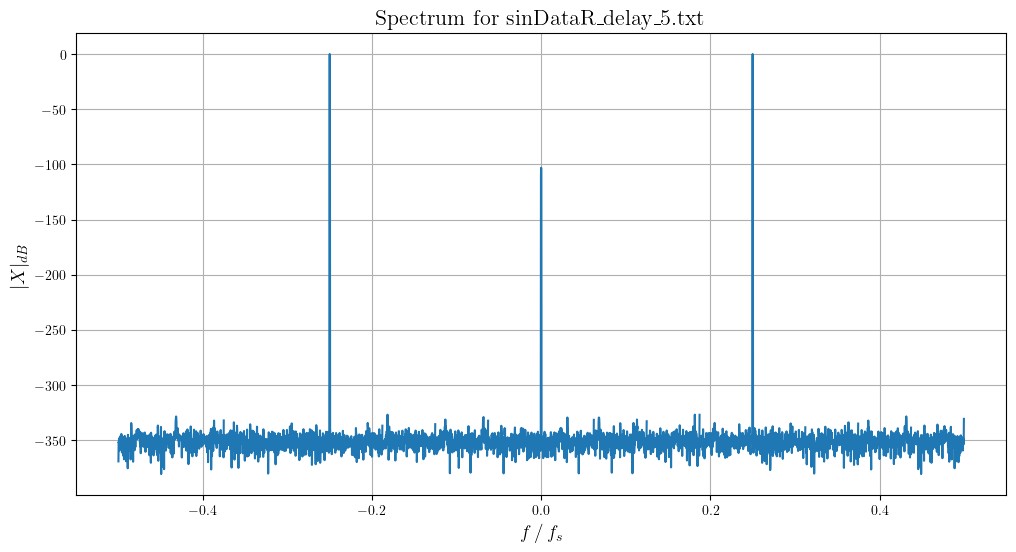

Processed real data from output/sinDataR_delay_5.txt
Processing file: output/sinDataI_delay_25.txt
{'file_name': 'sinDataI_delay_25.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 1.0}
1
1
Saved spectrum plot to ./figs/sinDataI_delay_25_spectrum.png


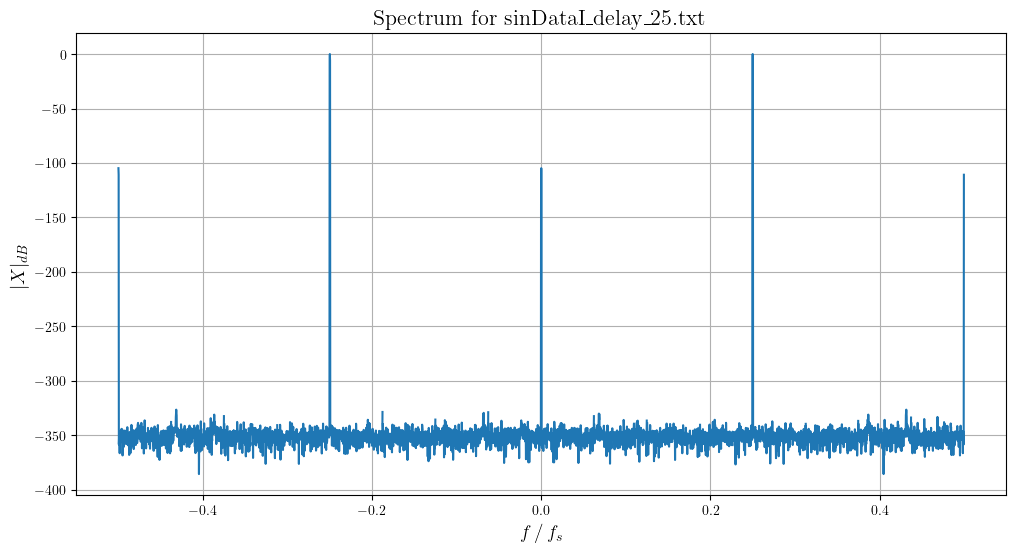

Processed real data from output/sinDataI_delay_25.txt
Processing file: output/sinDataR_OSR_8.txt
{'file_name': 'sinDataR_OSR_8.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 8.0}
1
1
Saved spectrum plot to ./figs/sinDataR_OSR_8_spectrum.png


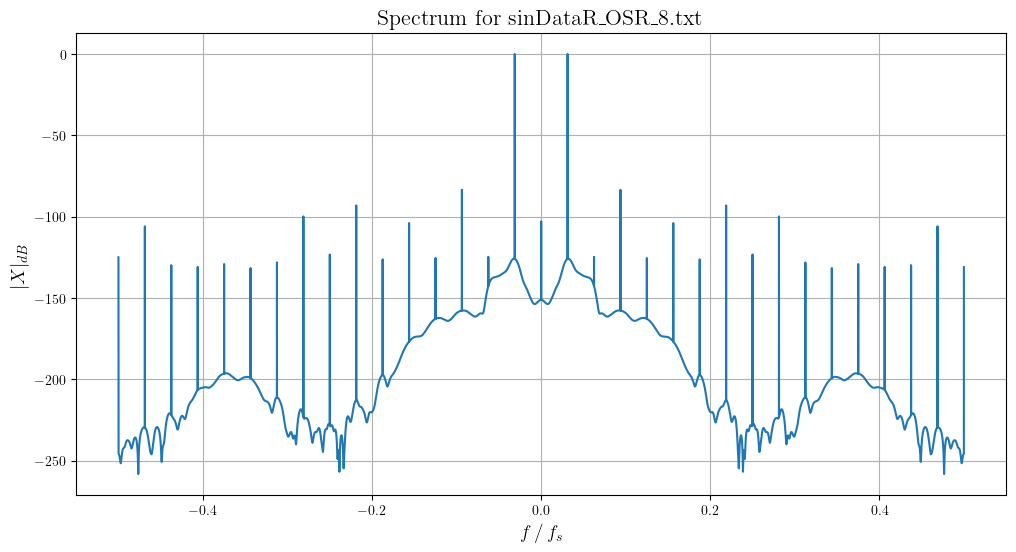

Processed real data from output/sinDataR_OSR_8.txt
Processing file: output/sinDataI_OSR_8.txt
{'file_name': 'sinDataI_OSR_8.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 8.0}
1
1
Saved spectrum plot to ./figs/sinDataI_OSR_8_spectrum.png


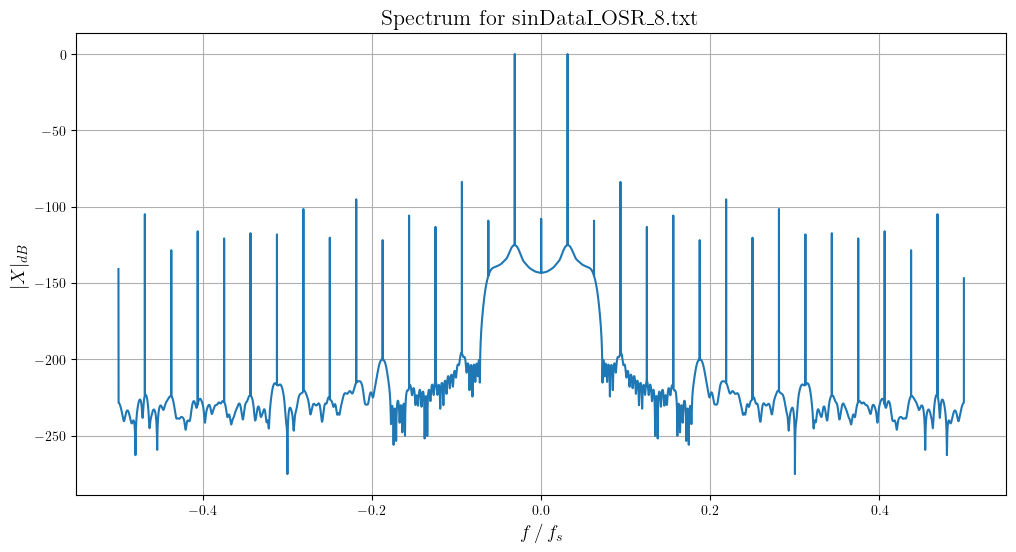

Processed real data from output/sinDataI_OSR_8.txt
Processing file: output/sinDataR_deltaSigma.txt
{'file_name': 'sinDataR_deltaSigma.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 8.0}
1
1
Saved spectrum plot to ./figs/sinDataR_deltaSigma_spectrum.png


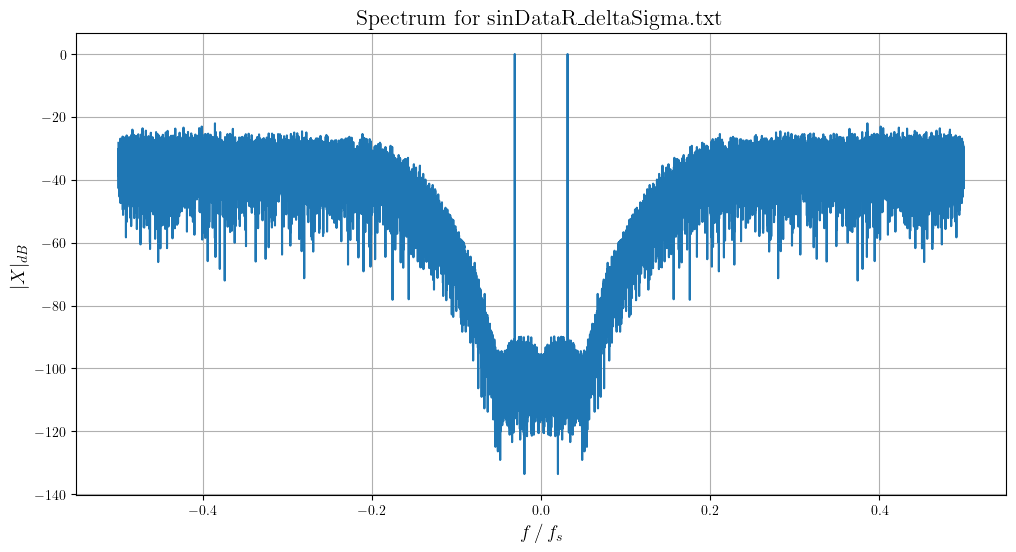

Processed real data from output/sinDataR_deltaSigma.txt
Processing file: output/sinDataI_deltaSigma.txt
{'file_name': 'sinDataI_deltaSigma.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 8.0}
1
1
Saved spectrum plot to ./figs/sinDataI_deltaSigma_spectrum.png


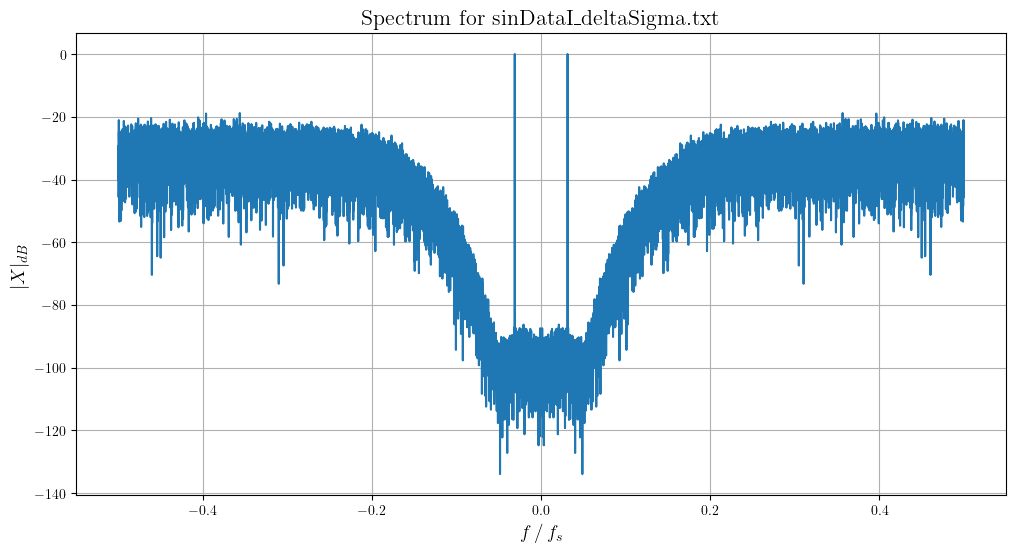

Processed real data from output/sinDataI_deltaSigma.txt
Processing file: output/sinData_deltaSigma_double.txt
{'file_name': 'sinData_deltaSigma_double.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 8.0}
1
1
Saved spectrum plot to ./figs/sinData_deltaSigma_double_spectrum.png


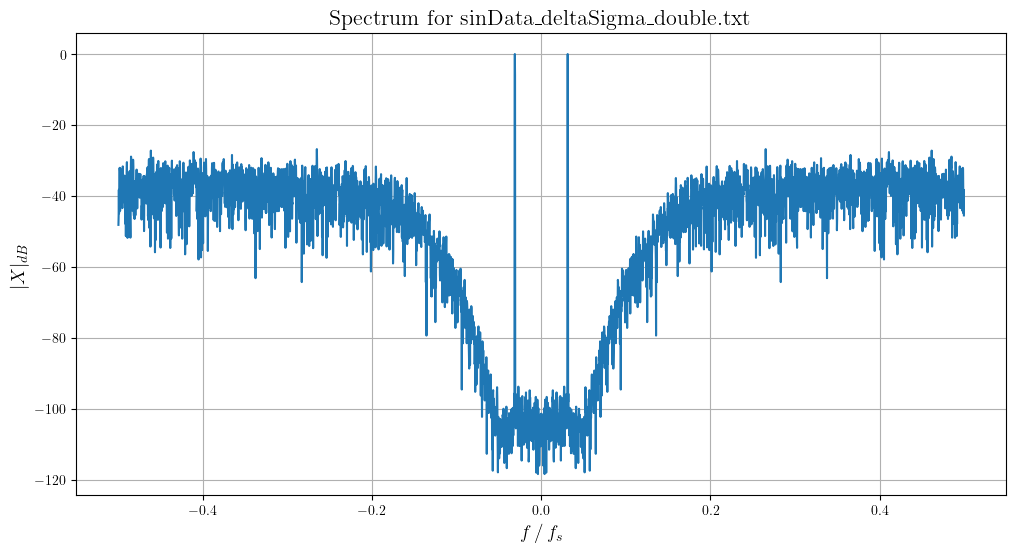

Processed real data from output/sinData_deltaSigma_double.txt


In [145]:
#!/usr/bin/env python3

import os
import sys
import numpy as np
import scipy.signal as signal
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def read_file_with_header(file_path):
    """
    Reads a file with metadata in the header and numerical data below.
    Checks the filename for specific keywords like 'Complex' or 'LUT'.
    
    Args:
        file_path (str): Path to the input file.
    
    Returns:
        dict: Metadata key-value pairs, including file name details.
        np.ndarray: Numerical data as a NumPy array.
    """
    metadata = {}
    data = []

    # Extract the filename
    file_name = os.path.basename(file_path)
    metadata['file_name'] = file_name  # Store the filename in metadata

    # Check if the filename contains specific keywords
    metadata['contains_Complex'] = 'Complex' in file_name
    metadata['contains_LUT'] = 'LUT' in file_name

    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                key_value = line[1:].strip().split("=")  # Metadata in format `key=value`
                if len(key_value) == 2:
                    key, value = key_value[0].strip(), key_value[1].strip()
                    try:
                        # Convert numeric metadata to float if possible
                        metadata[key] = float(value) if value.replace('.', '', 1).isdigit() else value
                    except ValueError:
                        metadata[key] = value
            else:
                try:
                    # Read data based on metadata
                    if metadata.get('complex', 0) == 1:  # If complex metadata is 1
                        real, imag = map(float, line.strip().split())
                        data.append(complex(real, imag))
                    else:  # If complex metadata is 0
                        data.append(float(line.strip()))
                except ValueError:
                    pass  # Ignore non-numeric lines

    return metadata, np.array(data)

def process_file(file_path):
    """
    Processes a single file, extracting metadata, computing the spectrum, and saving plots.
    
    Args:
        file_path (str): Path to the file.
    """
    print(f"Processing file: {file_path}")
    metadata, data = read_file_with_header(file_path)
    print(metadata)

    if not data.size:
        print(f"Warning: No valid numerical data found in {file_path}")
        return

    # Extract metadata
    OSR = int(metadata.get("OSR", 1))
    is_complex = metadata.get("complex", 0) == 1  # Check if the data is complex
    lut_width = metadata.get("lut_width", 1)

    # Compute the windowed data and spectrum
    print(lut_width)
    w = signal.windows.hann(len(data), False)
    data_win = data * w
    spectrum = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(data_win))))
    spectrum -= np.max(spectrum)
    freqs = (np.arange(len(data)) / len(data) - 0.5)

    # Plot the spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(freqs, spectrum, label="Spectrum")
    plt.title(f"Spectrum for {os.path.basename(file_path)}", fontsize=16)
    plt.xlabel(r"$f \, / \, f_s$", fontsize=14)
    plt.ylabel(r"$|X|_{dB}$", fontsize=14)

    print(lut_width)
    x_min = -0.5/lut_width
    x_max = 0.5/lut_width
    y_min = np.min(spectrum[int((x_min+0.5)*len(spectrum)):int((x_max+0.5)*len(spectrum))])
    y_max = np.max(spectrum[int((x_min+0.5)*len(spectrum)):int((x_max+0.5)*len(spectrum))])

    # y_ticks = np.arange(y_max, y_min - 20, -20)  # Generate ticks from 0 to y_max with step of 20
    # plt.yticks(y_ticks)

    # plt.xlim([x_min, x_max])
    # plt.ylim(y_min - 5, y_max + 5)

    plt.grid()

    # Save the figure
    file_name = os.path.basename(file_path).replace('.txt', '_spectrum.png')
    fig_path = os.path.join("./figs", file_name)
    plt.savefig(fig_path)
    print(f"Saved spectrum plot to {fig_path}")
    # plt.close()
    plt.show();

    # Additional printout for complex vs real
    data_type = "complex" if is_complex else "real"
    print(f"Processed {data_type} data from {file_path}")

def main():
    file_path = "input/sinDataComplex.txt"
    process_file(file_path)
    file_path = "output/sinDataR_delay_5.txt"
    process_file(file_path)
    file_path = "output/sinDataI_delay_25.txt"
    process_file(file_path)
    file_path = "output/sinDataR_OSR_8.txt"
    process_file(file_path)
    file_path = "output/sinDataI_OSR_8.txt"
    process_file(file_path)
    file_path = "output/sinDataR_deltaSigma.txt"
    process_file(file_path)
    file_path = "output/sinDataI_deltaSigma.txt"
    process_file(file_path)

    file_path = "output/sinData_deltaSigma_double.txt"
    process_file(file_path)

if __name__ == "__main__":
    main()


In [133]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from remezlp import remezlp

def genTestSpectrum(n, freq, amp, randPhase=False):
    # Generate test spectrum
    # Arguments:
    #    n    - number of samples
    #    freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
    #    amp  - tuple of amplitudes (ampStart, ampEnd)
    #    randPhase - if True, assign random phase to each sample
    x = np.zeros(n, dtype='complex128')
    freqStart, freqEnd = freq
    ampStart, ampEnd = amp
    indStart = round(n*freqStart)
    indEnd = round(n*freqEnd)
    x[indStart:indEnd] = ampStart - np.linspace(0, 1, num=indEnd-indStart) * (ampStart-ampEnd)
    if randPhase:
        x[indStart:indEnd] *= np.exp(1j*2*np.pi*np.random.rand(indEnd-indStart)) # randomize phase
    x[0] = abs(x[1])/2
    timeDomain = np.fft.ifft(x)
    return(timeDomain)
    
def expander(x, I):
    # Upsample the signal by factor I
    #   x - input signal
    #   I - upsampling factor
    nx = len(x)
    xI = np.zeros(nx*I, dtype=complex)
    xI[::I] = x
    return xI

def compressor(x, D):
    # Downsample the signal by factor D
    #   x - input signal
    #   D - downsampling factor
    return x[0::D]

def plotdB(x, win=False, epsilon=1e-12):
    if win==True:
        w = signal.windows.hamming(len(x), False)
        x *= w
    x += epsilon
    XdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x)) + epsilon))
    XdB -= np.max(XdB)
    freqs = np.arange(len(x))/len(x) - 0.5

    plt.plot(freqs, XdB)
    plt.grid()
    # plt.show();

def plot(x, win=False, epsilon=1e-15):
    if win==True:
        w = signal.hann(len(x), False)
        x *= w
    Xfft = np.abs(np.fft.fftshift(np.fft.fft(x)))
    Xfft /= np.max(Xfft)
    freqs = np.arange(len(x))/len(x) - 0.5
    plt.plot(freqs, Xfft)
    plt.grid()
    

def makePolyphase(coeff, M):
    # Split coefficients into polyphase components
    n = int(np.ceil(len(coeff)/M))
    tmp = np.zeros(n*M)
    tmp[:len(coeff)] = coeff
    polyCoeff = np.zeros((M,n))
    for i in range(M):
        polyCoeff[i,:] = tmp[i::M]
    return polyCoeff

def polyI(x, firCoeff, I):
    polyFIR = makePolyphase(firCoeff, I)
    xPoly = np.zeros(len(x)*I, dtype=x.dtype)
    for i in range(I):
        tmp = signal.lfilter(polyFIR[i], 1.0, np.concatenate((x, x[:int(len(firCoeff)/I-1)])))
        tmp = tmp[int(len(firCoeff)/I-1):]
        xPoly[i::I] = tmp
    return xPoly

def polyD(x, firCoeff, D):
    polyFIR = makePolyphase(firCoeff, I)
    x_ = np.concatenate((x, x[:int(len(firCoeff)-1)]))
    y = []
    for i in range(D):
        FIRin = x_[i::D]
        tmp = signal.lfilter(polyFIR[D-1-i], 1.0, FIRin)
        y = np.append(y, tmp)
    y = np.array(y)
    return y

def fftdB(x, epsilon=1e-12):
    return 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x)) + epsilon))

def interpolate(x, I, F, delta, show=False, prt=False):
    N = len(x)
    Fpass, Fstop = F[0], F[1]
    deltaPass, deltaStop = delta[0], delta[1]

    Fpass_arr = []
    Fstop_arr = []
    dF = []
    N_fir = []
    firCoeffs = []

    iterator = int(np.log(I)/np.log(2))
    for i in range(iterator):
        Fstop = (1 - Fpass)/2
        Fpass /= 2
        firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = False, nPoints=N, Nmax=N)
        # x = expander(x, 2)
        # x = signal.lfilter(firCoeff, 1.0, np.concatenate((x, x[:len(firCoeff)-1])))[len(firCoeff)-1:]
        x = polyI(x, firCoeff, 2)

        firCoeffs.append(firCoeff)
        Fpass_arr.append(Fpass)
        Fstop_arr.append(Fstop)
        dF.append(Fstop - Fpass)
        N_fir.append(firCoeff.size)
        if show:
            plotdB(x)
            plt.plot([-0.5,0.5], [-AdB, -AdB], '--r')
            plt.ylim([-150, 10])
            plt.show();
    if prt:
        print(f"Fpass = {Fpass_arr}")
        print(f"Fstop = {Fstop_arr}")
        print(f"dF = {dF}")
        print(f"N_fir = {N_fir}")
        print(firCoeffs)

    return x

def delay(x, firCoeff, I, l):
    polyFIR = makePolyphase(firCoeff, I)
    delayFIR = polyFIR[l]
    delay = int((len(firCoeff) - 1)/I/2)
    y = signal.lfilter(delayFIR, 1.0, x)
    y = y[delay:]
    return y

Fmax = 0.425


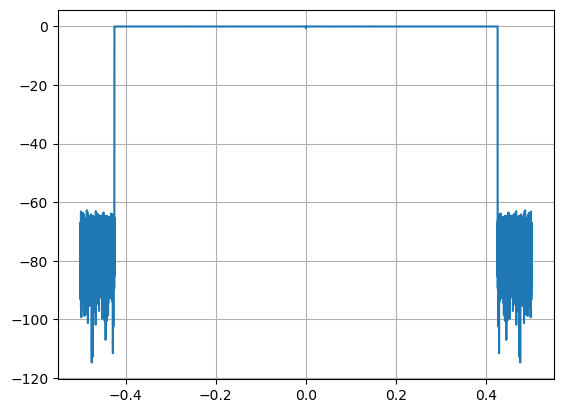

In [134]:
I = 8
N = 2**16
n = np.arange(N)

perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

AdB = 60
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

F = [0.0, Fmax]
A = [1.0, 1.0]
x = 2*genTestSpectrum(N, F, A, True).real
amp = 1e-6
x += np.random.normal(-amp, amp, len(x))
plotdB(x, False)

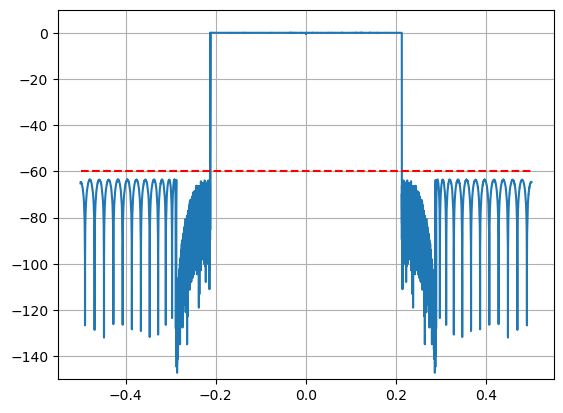

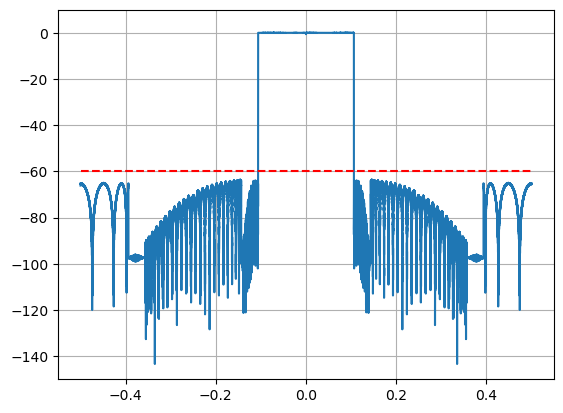

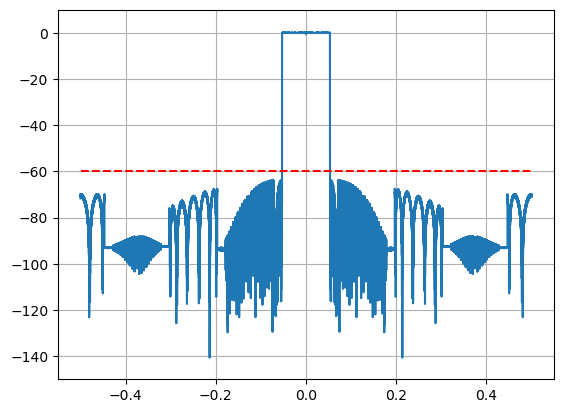

Fpass = [0.2125, 0.10625, 0.053125]
Fstop = [0.2875, 0.39375, 0.446875]
dF = [0.07499999999999998, 0.2875, 0.39375000000000004]
N_fir = [47, 11, 7]
[array([-8.29782898e-04, -3.14502611e-06,  1.50946649e-03,  1.88127428e-06,
       -2.79362858e-03, -6.46521600e-06,  4.72907470e-03,  5.28063189e-06,
       -7.51482450e-03, -1.01561872e-05,  1.14516105e-02,  9.67228666e-06,
       -1.69746701e-02, -1.47693676e-05,  2.48898199e-02,  1.37836841e-05,
       -3.68574681e-02, -1.83196893e-05,  5.72484127e-02,  1.66721530e-05,
       -1.02143985e-01, -2.03872314e-05,  3.16973544e-01,  5.00017764e-01,
        3.16973544e-01, -2.03872314e-05, -1.02143985e-01,  1.66721530e-05,
        5.72484127e-02, -1.83196893e-05, -3.68574681e-02,  1.37836841e-05,
        2.48898199e-02, -1.47693676e-05, -1.69746701e-02,  9.67228666e-06,
        1.14516105e-02, -1.01561872e-05, -7.51482450e-03,  5.28063189e-06,
        4.72907470e-03, -6.46521600e-06, -2.79362858e-03,  1.88127428e-06,
        1.50946649e-03, -3

In [135]:
F = [Fmax, 1-Fmax]
delta = [deltaPass, deltaStop]
x_osr8 = interpolate(x, I, F, delta, show=True, prt=True)

In [137]:
I = 8
N = 2**16
n = np.arange(N)

perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")
F = [Fmax, 1-Fmax]

AdB = 100
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass
delta = [deltaPass, deltaStop]

F0 = 0.16
x = 1.0 * np.exp(1j * 2*np.pi*F0*n)

Fmax = 0.425


[0.08357681 0.503867   0.38018152 ... 0.34226926 0.49114258 0.18406545]


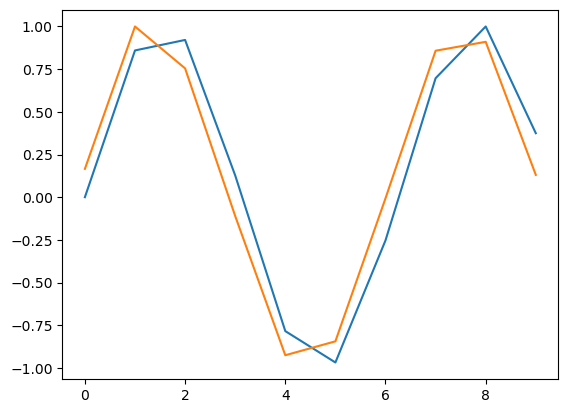

In [140]:
I = 2
Fpass = Fmax / I
Fstop = (1-Fmax) / I

firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = True, nPoints=N, Nmax=N)
x_delayed = delay(x.imag, firCoeff, I, 1)
print(x_delayed)

x_delayed /= np.max(x_delayed)
x_imag /= np.max(x_imag)

pp = 10
x_delayed_ = x_delayed[:pp]
x_imag = x.imag[:pp]

plt.plot(x_imag)
plt.plot(x_delayed_)

20
82
20


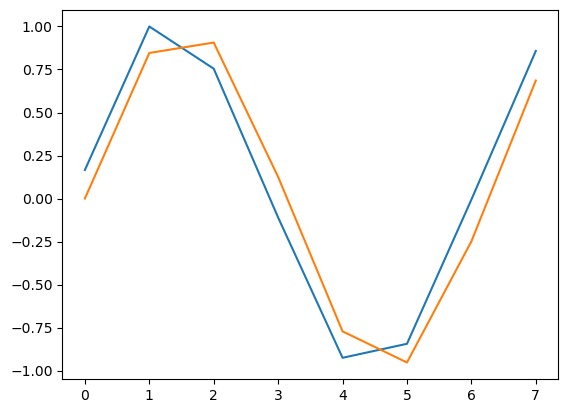

[-1.54984604e-05  3.90526466e-05 -8.82102761e-05  1.73846714e-04
 -3.13921295e-04  5.30800584e-04 -8.52357254e-04  1.31254384e-03
 -1.95229842e-03  2.82117009e-03 -3.98033167e-03  5.50838175e-03
 -7.51269685e-03  1.01521151e-02 -1.36848953e-02  1.85788314e-02
 -2.57990367e-02  3.77247228e-02 -6.22088820e-02  1.49110456e-01
  4.49917355e-01 -8.86152259e-02  4.74659761e-02 -3.10118408e-02
  2.18978808e-02 -1.60070475e-02  1.18646928e-02 -8.81145513e-03
  6.50509211e-03 -4.74588334e-03  3.40494293e-03 -2.39143724e-03
  1.63663372e-03 -1.08580192e-03  6.94019045e-04 -4.24010653e-04
  2.44917092e-04 -1.31624144e-04  6.39362400e-05 -2.74128709e-05
  7.79053911e-06]


In [98]:
Fpass = Fmax
Fstop = 1-Fmax

I = 2

Fpass /= I
Fstop /= I
firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = True, nPoints=N, Nmax=N)

polyFIR = makePolyphase(firCoeff, I)
fir = polyFIR[1]
xI_delay = signal.lfilter(fir, 1.0, x.imag)
# xI_delay = xI_delay[int(len(firCoeff)/I-1):]
# xR_delay = delay(x.real, firCoeff, 4, 2)
# x_delay = xR_delay + 1j * xI_delay
# x_delay = x.imag[100:]
delay = int((len(firCoeff)/I-1)/2)
# delay = int((len(fir)-1)/2)
print(delay)
# delay = 0
print(len(firCoeff))
print(delay)
pp = 8
xI_delay = xI_delay[delay:delay+pp]
x_imag = x.imag[0:pp]

xI_delay /= np.max(xI_delay)
x.imag /= np.max(x.imag)

plt.plot(xI_delay)
plt.plot(x_imag)
# plt.xlim([0, 20])
plt.show()

# Xfft = np.fft.fftshift(np.fft.fft(x_delay))
# XfftdB = 20 * np.log10(np.abs(Xfft) + 1e-15)
# XfftPhase = np.unwrap(np.angle(Xfft))

# Xfft_o = np.fft.fftshift(np.fft.fft(x))
# XfftPhase_o = np.unwrap(np.angle(Xfft_o))

# plt.plot(XfftdB)
# plt.show();

# plt.plot(XfftPhase)
# plt.plot(XfftPhase_o)
# # plotdB(x_delay)
# # plt.ylim([-AdB - 100, 5])
# plt.show();
print(fir)

In [89]:
(165)/4 / 2

20.625

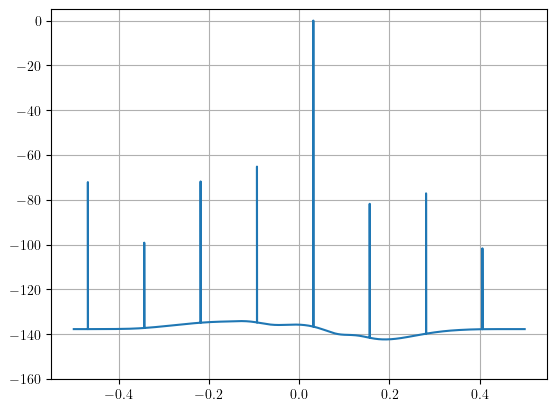

In [62]:
xReal_osr8 = interpolate(x.real, I, F, delta, show=False, prt=False)
xImag_osr8 = interpolate(x.imag, I, F, delta, show=False, prt=False)
x_osr8 = xReal_osr8 + 1j*xImag_osr8

plotdB(x_osr8)
plt.ylim([-AdB - 100, 5])
plt.show();